In [54]:
from cProfile import label
import time
import argparse
from xmlrpc.client import boolean
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import torch
import torch.nn.functional as F
import torch.optim as optimize 
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
from util.func import csv2numpy
import glob

import matplotlib.pyplot as plt
from PIL import Image
import cv2
from util.dataloader import IRT, IRTHybrid
from torch.utils.data import DataLoader
from models.CNN import AlexNet, EfficientNet

In [55]:
test = 1
speed = '20Hz'
direc = 'lateral'
img_list = sorted(glob.glob(os.path.join('data', str(test), speed, 'images', '*.png'), recursive=True))
irt_list = sorted(glob.glob(os.path.join('data', str(test), speed, 'thermal_mat', '*.csv'), recursive=True))

len(irt_list), len(img_list)

# plt.imshow(cv2.imread(img_list[10]))

(43, 43)

In [25]:
(img.shape[1]-irt.shape[1])/2

-47.0

data/1/20Hz/thermal_mat/R000191.csv data/1/20Hz/images/R000191.png
(480, 640, 3) (480, 640)


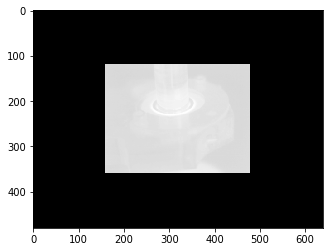

In [83]:
img = cv2.imread(img_list[0])
# img = cv2.resize(img, (227,227), interpolation=cv2.INTER_CUBIC)
irt = csv2numpy(irt_list[0])
irt = np.pad(irt, ((120,120),(159, 160)))
plt.imshow(irt, cmap = 'gray')
print(irt_list[0], img_list[0])
print(img.shape, irt.shape)

In [27]:
df_img = pd.read_csv('thermal_img.csv', index_col=0).sort_values(by=['path'])
df_irt = pd.read_csv('thermal_mat.csv', index_col=0).sort_values(by=['path'])
print(df_img.head(3))
print(df_irt.head(3))

                                       path category  label
44   data/0/60Hz/images/IR20211103_2275.png       S0      0
137  data/0/60Hz/images/IR20211103_2276.png       S0      0
390  data/0/60Hz/images/IR20211103_2277.png       S0      0
                                            path category  label
499  data/0/60Hz/thermal_mat/IR20211103_2275.csv       S0      0
40   data/0/60Hz/thermal_mat/IR20211103_2276.csv       S0      0
301  data/0/60Hz/thermal_mat/IR20211103_2277.csv       S0      0


(120, 161) (240, 321)


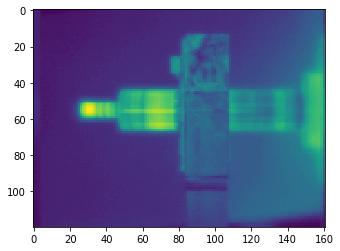

In [69]:
img = cv2.imread(df_img.path[1000])
img = csv2numpy(df_irt.path[0])
img = cv2.resize(img, (321,240), interpolation=cv2.INTER_CUBIC)  #W,H,C   [200, 300, 3]
img1 = csv2numpy(df_irt.path[1000])
# img = np.rot90(img)
# img = cv2.resize(img, (480,640), interpolation=cv2.INTER_CUBIC)  #W,H,C   [200, 300, 3]
print(img.shape, img1.shape)
plt.imshow(img)

In [70]:
class args: pass
args.cuda = True
args.device = 3

args.epochs = 100
args.batchSize = 5
args.dataAugmentation =False
args.log_interval=100
args.lr = 1e-4
args.momentum = 0.9
args.dtype = 'img'
args.seed = 1

In [71]:
class AlexNet_(nn.Module):
    
    def __init__(self, dtype):
        super(AlexNet_, self).__init__()

        ##Combinada
        if dtype == 'img':
            self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 9, stride=2, padding=0 ) 
            self.batchNorm1 = nn.BatchNorm2d(num_features=96), 
            self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 
            self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 4)
            self.weight2 = self.conv2.weight.data.numpy()

            self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1) 
            self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1) 
            self.fc1  = nn.Linear(in_features= 3456, out_features= 2304)
            self.fc2  = nn.Linear(in_features= 2304, out_features= 4096)
            self.fc3  = nn.Linear(in_features= 4096, out_features= 4096)
            self.fc4 = nn.Linear(in_features=4096 , out_features=4)
        elif dtype == 'hybrid':
            self.conv1 = nn.Conv2d(in_channels=4, out_channels= 96, kernel_size= 9, stride=2, padding=0 ) 
            self.batchNorm1 = nn.BatchNorm2d(num_features=96), 
            self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 
            self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 4)
            self.weight2 = self.conv2.weight.data.numpy()

            self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1) 
            self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1) 
            self.fc1  = nn.Linear(in_features= 3456, out_features= 2304)
            self.fc2  = nn.Linear(in_features= 2304, out_features= 4096)
            self.fc3  = nn.Linear(in_features= 4096, out_features= 4096)
            self.fc4 = nn.Linear(in_features=4096 , out_features=4)
        elif dtype == 'irt':
            print('using irt_mat data')
            self.conv1 = nn.Conv2d(in_channels=1, out_channels= 96, kernel_size= 9, stride=2, padding=0 ) 
            self.batchNorm1 = nn.BatchNorm2d(num_features=96), 
            self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 
            self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 4)
            self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1) 
            self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1) 
            self.fc1  = nn.Linear(in_features= 3456, out_features= 2304)
            self.fc2  = nn.Linear(in_features= 2304, out_features= 4096)
            self.fc3  = nn.Linear(in_features= 4096, out_features= 4096)
            self.fc4 = nn.Linear(in_features=4096 , out_features=4)

    def forward(self,img):

        x = F.relu(self.conv1(img)) # out_dim [110x110x96]
        x = self.maxpool(x) # out_dim [55x55x96]
        x = F.relu(self.conv2(x))  # out_dim [29x29x256]
        x = self.maxpool(x)  # out_dim [14x14x256]
        # plt.imshow(self.weight2[0, 2])
        # plt.show()
        x = F.relu(self.conv3(x)) # out_dim [14x14x384]
        x = self.maxpool(x)  # out_dim [7x7x256]
        x = F.relu(self.conv4(x)) # out_dim [8x8x384]
        x = self.maxpool(x)  # out_dim [4x4x256]
        x = self.maxpool(x)  # out_dim [6x6x256]
        x = x.reshape(x.shape[0], -1)  # out_dim [9216x1]
        x = F.relu(self.fc1(x)) # out_dim [4096x1]
        x = F.relu(self.fc2(x)) # out_dim [4096x1]
        x = F.relu(self.fc3(x)) # out_dim [4096x1]
        x = self.fc4(x) # out_dim [1000x1]

        return x

In [72]:
np.array(df_img['path']).T

array(['data/0/60Hz/images/IR20211103_2275.png',
       'data/0/60Hz/images/IR20211103_2276.png',
       'data/0/60Hz/images/IR20211103_2277.png', ...,
       'data/3/60Hz/images/R20211117_3737.png',
       'data/3/60Hz/images/R20211117_3738.png',
       'data/3/60Hz/images/R20211117_3739.png'], dtype=object)

In [73]:
np.reshape(np.array(df_img['path']), (2298,1))

array([['data/0/60Hz/images/IR20211103_2275.png'],
       ['data/0/60Hz/images/IR20211103_2276.png'],
       ['data/0/60Hz/images/IR20211103_2277.png'],
       ...,
       ['data/3/60Hz/images/R20211117_3737.png'],
       ['data/3/60Hz/images/R20211117_3738.png'],
       ['data/3/60Hz/images/R20211117_3739.png']], dtype=object)

In [74]:
paths = np.concatenate((np.reshape(np.array(df_img['path']), (2298,1)), np.reshape(np.array(df_irt['path']), (2298,1))), 1)
labels = np.concatenate((np.reshape(np.array(df_img['label']), (2298,1)), np.reshape(np.array(df_irt['label']), (2298,1))), 1)
paths[0], labels[0]

(array(['data/0/60Hz/images/IR20211103_2275.png',
        'data/0/60Hz/thermal_mat/IR20211103_2275.csv'], dtype=object),
 array([0, 0]))

In [75]:
dtype = 'hybrid'

if dtype == 'img':
    x_train, x_test, y_train, y_test = train_test_split(df_img['path'].values, df_img['label'].values,
                                                            test_size=0.3,
                                                            random_state=1234,
                                                            stratify=df_img['label'])
elif dtype == 'irt':
    x_train, x_test, y_train, y_test = train_test_split(df_irt['path'].values, df_irt['label'].values,
                                                            test_size=0.3,
                                                            random_state=1234,
                                                            stratify=df_irt['label'])
elif dtype == 'hybrid':
    paths = np.concatenate((np.reshape(np.array(df_img['path']), (2298,1)), np.reshape(np.array(df_irt['path']), (2298,1))), 1)
    labels = np.concatenate((np.reshape(np.array(df_img['label']), (2298,1)), np.reshape(np.array(df_irt['label']), (2298,1))), 1)
    x_train, x_test, y_train, y_test = train_test_split(paths, df_img['label'].values,
                                                            test_size=0.3,
                                                            random_state=1234,
                                                            stratify=df_img['label'])

len(x_train), len(x_test), len(y_train), len(y_test)                                                        

(1608, 690, 1608, 690)

In [76]:
y_train[0]

0

In [77]:
len(x_train[:,0])

1608

In [78]:
import os
#from skimage import io, transform
import cv2 as cv
from numpy import dtype

import torch
from torch.utils.data import Dataset
from util.func import csv2numpy
import numpy as np


# Dataset class
class IRT_(Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, images_paths, labels, data_path, dtype = 'img', transform=None):
        super(IRT_, self).__init__()
        'Initialization'
        self.labels = labels
        self.images_paths = images_paths[:,0]
        self.irt_paths = images_paths[:,1]
        self.transform = transform
        self.data_path = data_path
        self.dtype = dtype

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.images_paths)

  def __getitem__(self, index):
      'Generates one sample of data'
      ## IRT DATA
      #   print(self.images_paths[index])
      path_irt = self.irt_paths[index]
      print(path_irt)
      # Load data and get label
      label = self.labels[index]
      irt = csv2numpy(path_irt)
      # irt = irt.flatten()
      print(irt.shape)
      irt= np.array([cv.resize(irt, (227,227), interpolation=cv.INTER_CUBIC)])  #W,H,C   [200, 300, 3]
      # image = image.transpose(2, 0, 1) #C,W,H  [3,200,300]

      ## IMG DATA

      'Generates one sample of data'
      #   print(self.images_paths[index])
      path = self.images_paths[index]
      
      # Load data and get label
      label = self.labels[index]
      image = cv.imread(path, cv.IMREAD_COLOR)
      #   print(image.shape)
      image= cv.resize(image, (227,227), interpolation=cv.INTER_CUBIC)  #W,H,C   [200, 300, 3]
      image = image.transpose(2, 0, 1) #C,W,H  [3,200,300]
      # image = image.flatten()
      if self.transform:
            image = self.transform(image)
            irt = self.transform(irt)
      return image, irt, label
      
data_path = '/home/edgomez10/Project/TB-and-IB-analysis-of-IRT-for-the-state-assessment-of-rolling-bearings-using-DL/data'
train_set = IRT_(x_train, y_train, data_path=data_path, transform=None, dtype = 'img')
train_loader = DataLoader(train_set, batch_size=5, shuffle=True)

In [80]:
img = train_set.__getitem__(0)[0]#.shape
irt = train_set.__getitem__(0)[1]#.shape
print(irt.shape)
print(type(irt))
# np.concatenate((img, irt), axis = 0)
# cv.resize(irt, (227,227), interpolation=cv.INTER_CUBIC).shape

# plt.imshow(train_set.__getitem__(0)[1][0,:])

data/0/60Hz/thermal_mat/IR20211103_2355.csv
(120, 161)
data/0/60Hz/thermal_mat/IR20211103_2355.csv
(120, 161)
(1, 227, 227)
<class 'numpy.ndarray'>


In [87]:
data = next(iter(train_loader))
img = torch.Tensor.float(data[0])
print(img.shape)
torch.std(img, dim=1).shape
# print('mean',torch.Tensor.float(data[0]).mean())
# print('std',torch.Tensor.float(data[0]).std())
# print('std',torch.Tensor.float(data[0]))

data/1/60Hz/thermal_mat/IR000044.csv
(240, 321)
data/1/40Hz/thermal_mat/IR000181_13.csv
(240, 321)
data/2/60Hz/thermal_mat/IR000053.csv
(240, 321)
data/2/60Hz/thermal_mat/IR000198.csv
(240, 321)
data/3/60Hz/thermal_mat/R20211117_3607.csv
(120, 161)
torch.Size([5, 3, 227, 227])


torch.Size([5, 227, 227])

In [22]:
class HyAlexNet_(nn.Module):
    
    def __init__(self, dtype):
        super(HyAlexNet_, self).__init__()

        ##Combinada
        if dtype == 'img':
            self.conv1 = nn.Conv2d(in_channels=3, out_channels= 96, kernel_size= 9, stride=2, padding=0 ) 
            self.batchNorm1 = nn.BatchNorm2d(num_features=96), 
            self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 
            self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 4)
            self.weight2 = self.conv2.weight.data.numpy()

            self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1) 
            self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1) 
            self.fc1  = nn.Linear(in_features= 3456, out_features= 2304)
            self.fc2  = nn.Linear(in_features= 2304, out_features= 4096)
            self.fc3  = nn.Linear(in_features= 4096, out_features= 4096)
            self.fc4 = nn.Linear(in_features=4096 , out_features=4)
        elif dtype == 'hybrid':
            self.conv1 = nn.Conv2d(in_channels=4, out_channels= 96, kernel_size= 9, stride=2, padding=0 ) 
            self.batchNorm1 = nn.BatchNorm2d(num_features=96), 
            self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 
            self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 4)
            self.weight2 = self.conv2.weight.data.numpy()

            self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1) 
            self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1) 
            self.fc1  = nn.Linear(in_features= 3456, out_features= 2304)
            self.fc2  = nn.Linear(in_features= 2304, out_features= 4096)
            self.fc3  = nn.Linear(in_features= 4096, out_features= 4096)
            self.fc4 = nn.Linear(in_features=4096 , out_features=4)
        elif dtype == 'irt':
            print('using irt_mat data')
            self.conv1 = nn.Conv2d(in_channels=1, out_channels= 96, kernel_size= 9, stride=2, padding=0 ) 
            self.batchNorm1 = nn.BatchNorm2d(num_features=96), 
            self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 
            self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride= 1, padding= 4)
            self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride= 1, padding= 1) 
            self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1) 
            self.fc1  = nn.Linear(in_features= 3456, out_features= 2304)
            self.fc2  = nn.Linear(in_features= 2304, out_features= 4096)
            self.fc3  = nn.Linear(in_features= 4096, out_features= 4096)
            self.fc4 = nn.Linear(in_features=4096 , out_features=4)

    def forward(self,img, irt):
        img = torch.cat((img, irt), axis = 1)
        irt = torch.flatten(irt)
        x = F.relu(self.conv1(img)) # out_dim [110x110x96]
        x = self.maxpool(x) # out_dim [55x55x96]
        x = F.relu(self.conv2(x))  # out_dim [29x29x256]
        x = self.maxpool(x)  # out_dim [14x14x256]
        # plt.imshow(self.weight2[0, 2])
        # plt.show()
        x = F.relu(self.conv3(x)) # out_dim [14x14x384]
        x = self.maxpool(x)  # out_dim [7x7x256]
        x = F.relu(self.conv4(x)) # out_dim [8x8x384]
        x = self.maxpool(x)  # out_dim [4x4x256]
        x = self.maxpool(x)  # out_dim [6x6x256]
        x = x.reshape(x.shape[0], -1)  # out_dim [9216x1]
        x = torch.cat((x, irt))
        x = F.relu(self.fc1(x)) # out_dim [4096x1]
        x = F.relu(self.fc2(x)) # out_dim [4096x1]
        x = F.relu(self.fc3(x)) # out_dim [4096x1]
        x = self.fc4(x) # out_dim [1000x1]

        return x

In [23]:
model = HyAlexNet_(dtype='hybrid')
model.cuda(args.device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optimize.Adam(model.parameters(), lr = args.lr)
train_loss = 0
for batch_idx, (data, irt, target) in enumerate(train_loader):
    if args.cuda:
        data, irt,  target = data.cuda(args.device), irt.cuda(args.device),target.cuda(args.device)
    data, irt, target = Variable(data), Variable(irt), Variable(target)
    print('data shape: ', data.shape)
    print('irt shape: ', irt.shape)
    print('final im shape: ', torch.cat((data, irt), axis = 1).shape)
    print('target: ', target.shape)
    data = data.float()
    irt = irt.float()
    optimizer.zero_grad()

    scores = model(data, irt)
    loss = criterion(scores, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    if batch_idx % args.log_interval == 0:
        print(f'Batch: {batch_idx} --> Loss: {loss}')

torch.save(model.state_dict(), '%s/%s' % (args.bestmodel_path,args.save))

data/3/60Hz/thermal_mat/R20211117_3721.csv
(120, 161)
data/0/60Hz/thermal_mat/R20211110_2754.csv
(120, 161)
data/3/60Hz/thermal_mat/R20211117_3576.csv
(120, 161)
data/0/60Hz/thermal_mat/R20211110_2628.csv
(120, 161)
data/3/60Hz/thermal_mat/R20211117_3573.csv
(120, 161)
data shape:  torch.Size([5, 3, 227, 227])
irt shape:  torch.Size([5, 1, 227, 227])
final im shape:  torch.Size([5, 4, 227, 227])
target:  torch.Size([5])


RuntimeError: Given groups=1, weight of size [96, 4, 9, 9], expected input[5, 3, 227, 227] to have 4 channels, but got 3 channels instead

In [31]:
pr_model = torch.load('/home/edgomez10/Project/TB-and-IB-analysis-of-IRT-for-the-state-assessment-of-rolling-bearings-using-DL/Experiments_hybrid/alexnet_hybrid_noDA/epoch_20.pt')

model.load_state_dict(pr_model['state_dict'])

RuntimeError: Error(s) in loading state_dict for HyAlexNet_:
	size mismatch for conv1.weight: copying a param with shape torch.Size([96, 4, 9, 9]) from checkpoint, the shape in current model is torch.Size([96, 3, 9, 9]).

: 